In [6]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50  # Changed to ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import label_binarize


In [7]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [8]:
# Define paths
train_dir = r"D:\CAPSTONE 400A\chest.v1i.folder\train"
valid_dir = r"D:\CAPSTONE 400A\chest.v1i.folder\valid"
test_dir = r"D:\CAPSTONE 400A\chest.v1i.folder\test"

In [9]:
# Define image dimensions
img_height, img_width = 224, 224  # Adjust according to ResNet50 input shape
batch_size = 32

In [10]:
# Data Augmentation and Preprocessing
datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 18480 images belonging to 12 classes.
Found 888 images belonging to 12 classes.
Found 451 images belonging to 12 classes.


In [12]:
# Define ResNet50 model with custom layers
base_model = ResNet50(include_top=False, input_shape=(img_height, img_width, 3))  # Adjusted input shape

In [13]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

class_names = sorted(os.listdir(train_dir))
number_class=len(class_names)
print("Number Of Classes: ",number_class)
print("Classes name are : ",class_names)

Number Of Classes:  12
Classes name are :  ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']


In [14]:
model = Sequential()
model.add(base_model)  # Adding the ResNet50 base model
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Adding L2 regularization
model.add(Dropout(0.5))  # Adding dropout regularization
model.add(Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                3084      
                                                                 
Total params: 49281164 (187.99 MB)
Trainable params: 49228044 (187.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [16]:
import tensorflow as tf
opt = Adam(learning_rate=0.0001)
# Compile the model again after unfreezing layers
model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [17]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Define a callback to save the model with the best accuracy
mc = ModelCheckpoint('D:\CAPSTONE 400A\model\Best_Model_ResNet50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [18]:
# Initialize lists to store history
all_train_accuracy = []
all_val_accuracy = []
all_train_loss = []
all_val_loss = []
num_sessions = 2
epochs_per_session = 2

for session in range(num_sessions):
    start_epoch = session * epochs_per_session + 1
    end_epoch = start_epoch + epochs_per_session - 1
    print(f"Session {session + 1}: epochs {start_epoch}-{end_epoch}")

    # Train the model with fine-tuning
    history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n // train_generator.batch_size,
      epochs=epochs_per_session,
      validation_data=valid_generator,
      validation_steps=valid_generator.n // valid_generator.batch_size,
      callbacks=[mc, early_stopping]
    )

    # Append accuracy and loss values to lists
    all_train_accuracy.extend(history.history['accuracy'])
    all_val_accuracy.extend(history.history['val_accuracy'])
    all_train_loss.extend(history.history['loss'])
    all_val_loss.extend(history.history['val_loss'])

Session 1: epochs 1-2
Epoch 1/2
577/577 [==============================] - ETA: 0s - loss: 5.4541 - accuracy: 0.2087 
Epoch 1: val_accuracy improved from -inf to 0.11458, saving model to D:\CAPSTONE 400A\model\Best_Model_ResNet50.h5


C:\Users\shafeeq-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


577/577 [==============================] - 8445s 15s/step - loss: 5.4541 - accuracy: 0.2087 - val_loss: 4.3273 - val_accuracy: 0.1146
Epoch 2/2
577/577 [==============================] - ETA: 0s - loss: 3.3306 - accuracy: 0.3122 
Epoch 2: val_accuracy improved from 0.11458 to 0.21181, saving model to D:\CAPSTONE 400A\model\Best_Model_ResNet50.h5
577/577 [==============================] - 10929s 19s/step - loss: 3.3306 - accuracy: 0.3122 - val_loss: 3.7853 - val_accuracy: 0.2118
Session 2: epochs 3-4
Epoch 1/2
577/577 [==============================] - ETA: 0s - loss: 2.3798 - accuracy: 0.4623 
Epoch 1: val_accuracy improved from 0.21181 to 0.27315, saving model to D:\CAPSTONE 400A\model\Best_Model_ResNet50.h5
577/577 [==============================] - 9089s 16s/step - loss: 2.3798 - accuracy: 0.4623 - val_loss: 3.5176 - val_accuracy: 0.2731
Epoch 2/2
577/577 [==============================] - ETA: 0s - loss: 1.7855 - accuracy: 0.6599  
Epoch 2: val_accuracy did not improve from 0.27315

# Evaluation

In [19]:
# Assuming you have a test_generator for generating test data
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy}")

14/14 [==============================] - 43s 3s/step - loss: 4.0826 - accuracy: 0.2433
Test Accuracy: 0.2433035671710968


In [20]:
# Predict on test data
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred)

# Predict on test data without rounding
y_pred = model.predict(test_generator)

# Convert predicted probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

15/15 [==============================] - 42s 3s/step


In [21]:
# Evaluate model accuracy
accuracy = accuracy_score(test_generator.classes, y_pred_classes)
precision = precision_score(test_generator.classes, y_pred_classes, average='macro')  # Specify averaging strategy
recall = recall_score(test_generator.classes, y_pred_classes, average='macro')  # Specify averaging strategy
f1 = f1_score(test_generator.classes, y_pred_classes, average='macro')  # Specify averaging strategy

In [22]:
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.24168514412416853
Precision: 0.25535132334991023
Recall: 0.20487892203499858
F1-Score: 0.20064179151539496


In [23]:
# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[24  4  6 18  1  1  3  2  1  0  0 10]
 [12 14  3  6  1  2  1  0  0  0  0  4]
 [16  2  9 13  1  1  1  1  1  1  0  6]
 [11  8  5 12  1  1  0  0  1  0  0  5]
 [13  4  2  5  2  1  1  0  2  0  1  6]
 [ 8  1  1  1  2  3  1  0  6  0  0  5]
 [ 5  4  2  3  0  1  4  0  6  0  0  2]
 [17  1  3  3  2  0  1  0  1  0  0  3]
 [11  3  3  2  3  5  3  0 22  0  0  6]
 [ 4  1  0  1  1  0  0  0  1  1  0  0]
 [ 5  3  4  2  0  0  1  0  0  1  1  0]
 [11  0  0  2  0  1  1  0  3  0  0 17]]


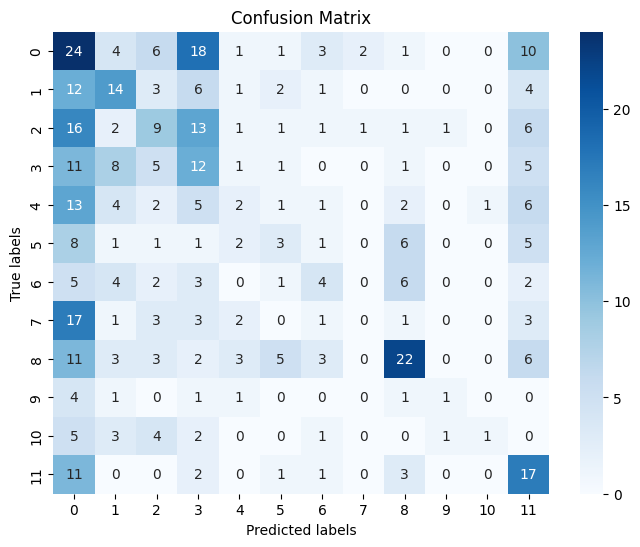

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [25]:
# Binarize the true labels
y_true_binary = label_binarize(test_generator.classes, classes=range(len(class_names)))

# Binarize the predicted probabilities
y_pred_binary = label_binarize(np.argmax(y_pred, axis=1), classes=range(len(class_names)))

In [26]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

print("Class names:", class_names)
print("Shape of y_true_binary:", y_true_binary.shape)
print("Shape of y_pred_binary:", y_pred_binary.shape)

Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']
Shape of y_true_binary: (451, 12)
Shape of y_pred_binary: (451, 12)


In [27]:
# Compute ROC curves for each class
if len(class_names) == 2:
    fpr[0], tpr[0], _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc[0] = auc(fpr[0], tpr[0])
else:
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

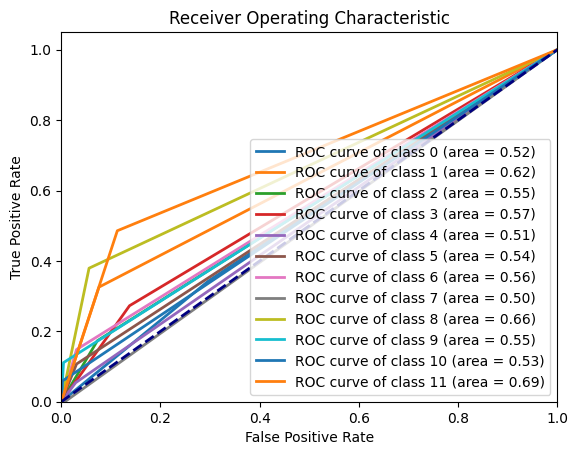

In [28]:
# Plot ROC curves for each class
plt.figure()
lw = 2
if len(class_names) == 2:
    plt.plot(fpr[0], tpr[0], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(0, roc_auc[0]))
else:
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

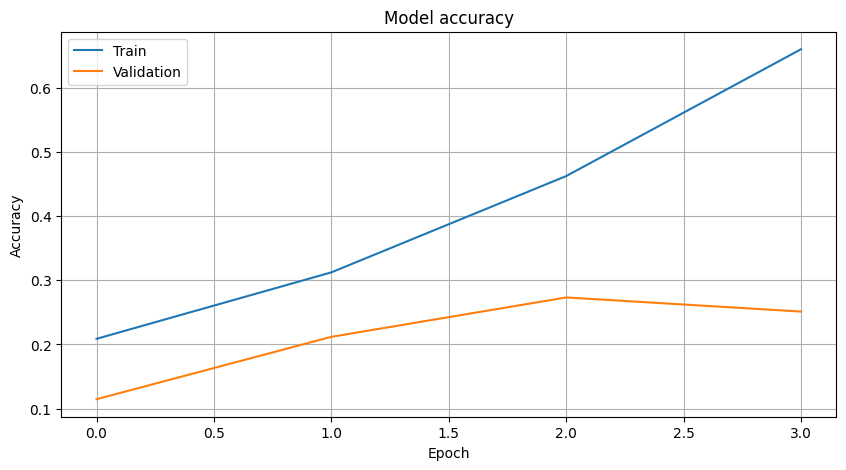

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(all_train_accuracy)
plt.plot(all_val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

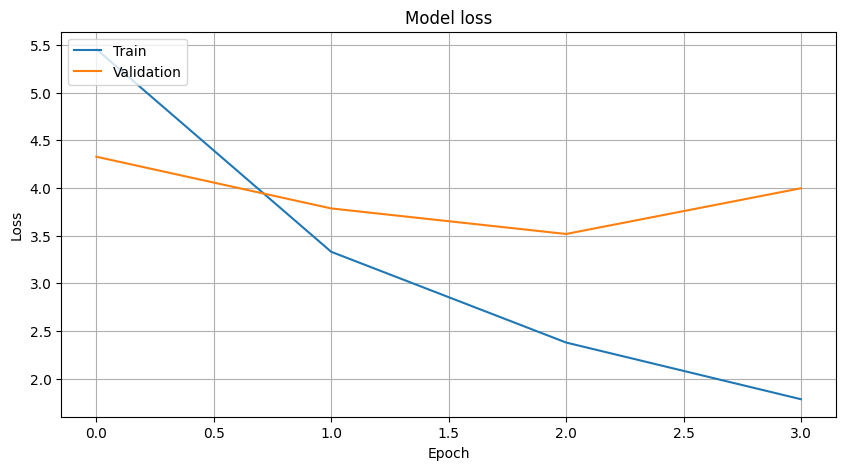

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

In [25]:
# Save the model
model.save('/content/drive/MyDrive/CSE438 (HASAN)/Saved Models/ResNet50.h5')

C:\Users\shafeeq-pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
